In [69]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

# conda activate is2022

In [70]:
NUM_ANS = 78
POSSIBLE_ANSWERS = [1,2,3]
participants_to_exclude = [
    "jason fong",
    "Dan test",
    "not applicable",
]
NUM_PARTICIPANTS_PER_TEST = 15

def get_aggregated_answers(csv_path):
    # load data from each test from csvs
    with open(csv_path) as f:
        all_lines = f.readlines()

    # only get the lines referring to specific participants
    lines = [l for l in all_lines if "anonymous,EN" in l]
    
    # exclude some participants
    new_lines = []
    for l in lines:
        exclude_participant = False
        for participant in participants_to_exclude:
            if participant in l:
                exclude_participant = True
                print("excluding", participant)
        if exclude_participant:
            pass
        else:
            new_lines.append(l)
            
    lines = new_lines

    aggregated_answers = defaultdict(Counter) # aggregated over all participants, key is question num, value is dict of answers to answer counts
    """
    aggregated_answers = {
        question1: {
            ans1: count_of_ans1,
            ans2: count_of_ans2,
            ans3: count_of_ans3,
        }, 
        question2: {
            ans1: count_of_ans1,
            ans2: count_of_ans2,
            ans3: count_of_ans3,
        }, 
        ...
    }
    """
    
    print(f"after filtering found {len(lines)} participants in {csv_path} which != {NUM_PARTICIPANTS_PER_TEST}")
    # assert len(lines) == NUM_PARTICIPANTS_PER_TEST
    
    lines = lines[:NUM_PARTICIPANTS_PER_TEST] # exclude latest participants (they shouldnt have been recruited!!!!)

    for line in lines:
        # get the answers for each participant
        answers = line.split("anonymous,EN")[-1].split(',')[3:-1] # upto but excluding last element as last question in survey is confirmation of working audio
        answers = [int(ans) for ans in answers]

        # assert that we have the correct number of answers and that they have the correct values
        assert len(answers) == NUM_ANS, len(answers)
        for ans in answers:
            assert ans in POSSIBLE_ANSWERS

        # aggregate the answer for this participant
        for question_num, ans in enumerate(answers, 1):
            aggregated_answers[question_num][ans] += 1
            
    return aggregated_answers

In [71]:
# create testnum + uttnum -> pair of conditions -> conditions mapping 
ranges = [ # range of questions related to each condition pair
    (0,13), # for first condition pair
    (13,26), # for second condition pair
    (26,39), # etc.
    (39,52),
    (52,65),
    (65,78),
]

testnum2conditionpairs = { 
    1: ('A','B','F','C','E','D'), # test num to condition pairs 
    2: ('B','C','A','D','F','E'), 
    3: ('C','D','B','E','A','F'),
    4: ('D','E','C','F','B','A'),
    5: ('E','F','D','A','C','B'),
    6: ('F','A','E','B','D','C'),
}

letter2conditionpair = {
    'A': ("sac_grapheme", "vanillatts_grapheme"), # condition pair to system on left and system on right
    'B': ("sac_speechcode_us", "vanillatts_grapheme"),
    'C': ("sac_speechcode_us", "sac_grapheme"),
    'D': ("sac_speechcode_scot", "vanillatts_grapheme"),
    'E': ("sac_speechcode_scot", "sac_grapheme"),
    'F': ("sac_speechcode_scot", "sac_speechcode_us"),
}
    
def get_conditions(test_num, utt_num):
    assert 1 <= test_num <= 6
    assert 1 <= utt_num <= NUM_ANS

    # get the condition pair
    for condition_pair_idx, r in enumerate(ranges):
        if r[0] < utt_num <= r[1]:
            condition_pair = testnum2conditionpairs[test_num][condition_pair_idx]
            break

    # get the conditions from the condition pair
    cond1, cond2 = letter2conditionpair[condition_pair]
    # print("test_num", test_num, "utt_num", utt_num, "condition_pair", condition_pair,"cond1", cond1, "cond2", cond2)
    
    return cond1, cond2

In [72]:
def get_conditionpair2wincounts(aggregated_answers, test_num):

    conditionpair2wincounts = Counter()
    """
    conditionpair2wincounts = {
        (cond1,cond2): 5, # cond1 beats cond2 5 times
        (cond2,cond1): 50 # cond2 beats cond1 50 times
    }

    NB ties/draws give 0.5 of a win to both conditions
    """
    
    conditionpair2numwins_and_numdraws = defaultdict(Counter)
    """
    conditionpair2numwins_and_numdraws = {
        (cond1,cond2): {
            wins: 20
            draws: 12
        },
        (cond2,cond1): {
            wins: 5
            draws: 4
        } 
        ...
    }
    """
    

    # add wins to systems based on aggregated_answers and the pair of conditions
    for utt_num, answer2counts in aggregated_answers.items():
        # print(utt_num, answer2counts)
        cond1, cond2 = get_conditions(test_num, utt_num)
        if 1 in answer2counts: # cond1 won
            conditionpair2wincounts[(cond1, cond2)] += answer2counts[1]
            conditionpair2numwins_and_numdraws[(cond1, cond2)]['wins'] += answer2counts[1]
        if 2 in answer2counts: # cond2 won
            conditionpair2wincounts[(cond2, cond1)] += answer2counts[2]
            conditionpair2numwins_and_numdraws[(cond2, cond1)]['wins'] += answer2counts[2]
        if 3 in answer2counts: # cond1 and 2 drew
            conditionpair2wincounts[(cond1, cond2)] += 0.5 * answer2counts[3]
            # print("conditionpair2wincounts[(cond1, cond2)]", conditionpair2wincounts[(cond1, cond2)])
            conditionpair2wincounts[(cond2, cond1)] += 0.5 * answer2counts[3]
            conditionpair2numwins_and_numdraws[(cond1, cond2)]['draws'] += answer2counts[3]
            conditionpair2numwins_and_numdraws[(cond2, cond1)]['draws'] += answer2counts[3]

    return conditionpair2wincounts, conditionpair2numwins_and_numdraws

In [73]:
# use testnum + uttnum -> pair of conditions -> conditions mapping 
# to assemble counts of how many times one condition beats another condition
paths = [
    # "listening_test_data/IS2022 - Test 1 - Final_March 21, 2022_05.18.csv",
    # "listening_test_data/IS2022 - Test 2 - Final_March 21, 2022_05.19.csv",
    # "listening_test_data/IS2022 - Test 3 - Final_March 21, 2022_05.19.csv",
    # "listening_test_data/IS2022 - Test 4 - Final_March 21, 2022_05.19.csv",
    # "listening_test_data/IS2022 - Test 5 - Final_March 21, 2022_05.20.csv",
    # "listening_test_data/IS2022 - Test 6 - Final_March 21, 2022_05.20.csv",
"listening_test_data/IS2022 - Test 1 - Final_March 21, 2022_15.36.csv",
"listening_test_data/IS2022 - Test 2 - Final_March 21, 2022_15.37.csv",
"listening_test_data/IS2022 - Test 3 - Final_March 21, 2022_15.37.csv",
"listening_test_data/IS2022 - Test 4 - Final_March 21, 2022_15.38.csv",
"listening_test_data/IS2022 - Test 5 - Final_March 21, 2022_15.41.csv",
"listening_test_data/IS2022 - Test 6 - Final_March 21, 2022_15.41.csv",
]

alltests_conditionpair2wincounts = Counter()
alltests_conditionpair2numwins_and_numdraws = defaultdict(Counter)

# aggregate the wins across all the 6 tests
for test_num, csv_path in enumerate(paths, 1):
    conditionpair2wincounts, conditionpair2numwins_and_numdraws = get_conditionpair2wincounts(get_aggregated_answers(csv_path), test_num)
    for conditionpair, wincount in conditionpair2wincounts.items():
        # print("DEBUG", test_num, csv_path, conditionpair, wincount)
        alltests_conditionpair2wincounts[conditionpair] += wincount
        
    for conditionpair,numwins_and_numdraws in conditionpair2numwins_and_numdraws.items():
        # print(alltests_conditionpair2wincounts)
        # print(numwins_and_numdraws)
        alltests_conditionpair2numwins_and_numdraws[conditionpair]['wins'] += numwins_and_numdraws['wins']
        alltests_conditionpair2numwins_and_numdraws[conditionpair]['draws'] += numwins_and_numdraws['draws']

excluding jason fong
excluding Dan test
excluding not applicable
after filtering found 17 participants in listening_test_data/IS2022 - Test 1 - Final_March 21, 2022_15.36.csv which != 15
after filtering found 15 participants in listening_test_data/IS2022 - Test 2 - Final_March 21, 2022_15.37.csv which != 15
after filtering found 15 participants in listening_test_data/IS2022 - Test 3 - Final_March 21, 2022_15.37.csv which != 15
after filtering found 16 participants in listening_test_data/IS2022 - Test 4 - Final_March 21, 2022_15.38.csv which != 15
after filtering found 15 participants in listening_test_data/IS2022 - Test 5 - Final_March 21, 2022_15.41.csv which != 15
after filtering found 15 participants in listening_test_data/IS2022 - Test 6 - Final_March 21, 2022_15.41.csv which != 15


In [74]:
alltests_conditionpair2numwins_and_numdraws

defaultdict(collections.Counter,
            {('sac_grapheme',
              'vanillatts_grapheme'): Counter({'wins': 175, 'draws': 781}),
             ('vanillatts_grapheme',
              'sac_grapheme'): Counter({'wins': 214, 'draws': 781}),
             ('sac_speechcode_us',
              'vanillatts_grapheme'): Counter({'wins': 800, 'draws': 214}),
             ('vanillatts_grapheme',
              'sac_speechcode_us'): Counter({'wins': 156, 'draws': 214}),
             ('sac_speechcode_scot',
              'sac_speechcode_us'): Counter({'wins': 314, 'draws': 363}),
             ('sac_speechcode_us',
              'sac_speechcode_scot'): Counter({'wins': 493, 'draws': 363}),
             ('sac_speechcode_us',
              'sac_grapheme'): Counter({'wins': 848, 'draws': 214}),
             ('sac_grapheme',
              'sac_speechcode_us'): Counter({'wins': 108, 'draws': 214}),
             ('sac_speechcode_scot',
              'sac_grapheme'): Counter({'wins': 716, 'draws': 277}

In [75]:
# visualise this counts matrix
alltests_conditionpair2wincounts

Counter({('sac_grapheme', 'vanillatts_grapheme'): 565.5,
         ('vanillatts_grapheme', 'sac_grapheme'): 604.5,
         ('sac_speechcode_us', 'vanillatts_grapheme'): 907.0,
         ('vanillatts_grapheme', 'sac_speechcode_us'): 263.0,
         ('sac_speechcode_scot', 'sac_speechcode_us'): 495.5,
         ('sac_speechcode_us', 'sac_speechcode_scot'): 674.5,
         ('sac_speechcode_us', 'sac_grapheme'): 955.0,
         ('sac_grapheme', 'sac_speechcode_us'): 215.0,
         ('sac_speechcode_scot', 'sac_grapheme'): 854.5,
         ('sac_grapheme', 'sac_speechcode_scot'): 315.5,
         ('sac_speechcode_scot', 'vanillatts_grapheme'): 824.0,
         ('vanillatts_grapheme', 'sac_speechcode_scot'): 346.0})

In [76]:
def get_counts_matrix(conditionpair2wincounts):
    # save counts matrix in format ready for R and bradley terry analysis (perfmod version of BTL)
    c = np.zeros((4,4), dtype=float)

    # description from https://github.com/EllaKaye/BradleyTerryScalable
    # A matrix (either a base matrix or a class from the Matrix package), dimension K by K, 
    # where K is the number of items. The i, j-th element is wi**j, the number of times item i has beaten item j. 
    # Ties can be accounted for by assigning half a win (i.e. 0.5) to each item.
    
    cond2matrix_idx = {
        "vanillatts_grapheme": 0,
        "sac_grapheme": 1,
        "sac_speechcode_us": 2,
        "sac_speechcode_scot": 3,
    }
    
    for (cond1, cond2), count in conditionpair2wincounts.items():
        i, j = cond2matrix_idx[cond1], cond2matrix_idx[cond2]
        c[i][j] = count
    
    return c

In [77]:
c = get_counts_matrix(alltests_conditionpair2wincounts)
c

array([[  0. , 604.5, 263. , 346. ],
       [565.5,   0. , 215. , 315.5],
       [907. , 955. ,   0. , 674.5],
       [824. , 854.5, 495.5,   0. ]])

In [78]:
# create a pandas dataframe so we can label rows and columns
column_names = ["TTS-g", "SAC-g", "SAC-us", "SAC-scot"]
row_names = column_names.copy()
df = pd.DataFrame(c, columns=column_names, index=row_names)

In [79]:
df

,TTS-g,SAC-g,SAC-us,SAC-scot
TTS-g,0.0,604.5,263.0,346.0
SAC-g,565.5,0.0,215.0,315.5
SAC-us,907.0,955.0,0.0,674.5
SAC-scot,824.0,854.5,495.5,0.0


In [80]:
# total wins for each condition 
# add col that sums the wins for each condition / row 
df.sum(axis=1)

TTS-g       1213.5
SAC-g       1096.0
SAC-us      2536.5
SAC-scot    2174.0
dtype: float64

In [81]:
# total losses for each condition
df.sum(axis=0)

TTS-g       2296.5
SAC-g       2414.0
SAC-us       973.5
SAC-scot    1336.0
dtype: float64

In [82]:
np.savetxt("listening_test_data/counts_matrix.txt", c.astype(int), fmt='%i', delimiter=",")

# Use python package choix to get bradley terry estimates of quality for our conditions

In [83]:
from choix import lsr_pairwise_dense, ilsr_pairwise_dense #non iterative and iterative versions
import matplotlib.pyplot as plt

In [84]:
def counts_matrix_to_bradley_terry_plot(c, savepath=""):
    islr_res = ilsr_pairwise_dense(c).tolist()

    # list(zip(islr_res, column_names)) # unsorted
    # # sort cols by result value to make legend easier to read
    # sorted(zip(islr_res, column_names), reverse=True)

    fig, ax = plt.subplots()
    # ax.scatter(x=islr_res, y=np.array([0,0,0,0]))
    markers = ['^', 'o','X', 's',]
    colours = ['#6dda9d', '#e96860', '#7ea9e5', '#e46af0']
    for (x_val, label), marker, colour in zip(zip(islr_res, column_names), markers, colours):
    # for (x_val, label), marker, colour in zip(sorted(zip(islr_res, column_names), reverse=False), markers, colours):
        ax.scatter(x=x_val, y=[0.125], marker=marker, label=label, s=125, c=colour)

    ax.set_aspect(2)
    ax.grid(True, which='both', axis="x")

    #############################################
    # set the x-spine (see below for more info on `set_position`)
    # ax.spines['left'].set_position('zero')
    # turn off the right spine/ticks

    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    # ax.yaxis.tick_left()

    #############################################
    # set the y-spine
    ax.spines['bottom'].set_position('zero')

    #############################################
    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()

    ax.set_yticks([])

    #############################################
    # limits
    plt.xlim([-1, 1.01])
    plt.ylim([0, 0.25])

    ax.axvline(x=0.0035, color='k')
    ax.axhline(y=-0, color='k')

    legend = ax.legend(
        # loc="upper left", 
        bbox_to_anchor =(-0.03, 1.05),
    )

    legend.set_title("Conditions:")
    # legend.set_title(r"$\bf{Conditions}$")
                     # prop = {'size':15})
    legend._legend_box.align = "left"

    ax.set_xlabel("Condition Score")
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')

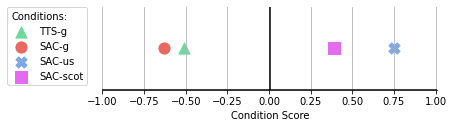

In [85]:
counts_matrix_to_bradley_terry_plot(c, savepath='plots/results.pdf')

# plot bradley terry for each target word individually for showing on the results page

In [86]:
def get_utt_num2conditionpair2wincounts(aggregated_answers, test_num):    
    utt_num2conditionpair2wincounts = {}
    
    # add wins to systems based on aggregated_answers and the pair of conditions
    for utt_num, answer2counts in aggregated_answers.items():
        conditionpair2wincounts = Counter()
        cond1, cond2 = get_conditions(test_num, utt_num)
        if 1 in answer2counts: # cond1 won
            conditionpair2wincounts[(cond1, cond2)] += answer2counts[1]
        if 2 in answer2counts: # cond2 won
            conditionpair2wincounts[(cond2, cond1)] += answer2counts[2]
        if 3 in answer2counts: # cond1 and 2 drew
            conditionpair2wincounts[(cond1, cond2)] += 0.5 * answer2counts[3]
            # print("conditionpair2wincounts[(cond1, cond2)]", conditionpair2wincounts[(cond1, cond2)])
            conditionpair2wincounts[(cond2, cond1)] += 0.5 * answer2counts[3]
    
        utt_num2conditionpair2wincounts[utt_num] = conditionpair2wincounts
    
    return utt_num2conditionpair2wincounts

all_utt_num2conditionpair2wincounts = defaultdict(Counter)

# aggregate across the 6 tests
for test_num, csv_path in enumerate(paths, 1):
    utt_num2conditionpair2wincounts = get_utt_num2conditionpair2wincounts(get_aggregated_answers(csv_path), test_num)
    for utt_num, conditionpair2wincounts in utt_num2conditionpair2wincounts.items():
        for conditionpair, wincounts in conditionpair2wincounts.items():
            all_utt_num2conditionpair2wincounts[utt_num][conditionpair] += wincounts
        

excluding jason fong
excluding Dan test
excluding not applicable
after filtering found 17 participants in listening_test_data/IS2022 - Test 1 - Final_March 21, 2022_15.36.csv which != 15
after filtering found 15 participants in listening_test_data/IS2022 - Test 2 - Final_March 21, 2022_15.37.csv which != 15
after filtering found 15 participants in listening_test_data/IS2022 - Test 3 - Final_March 21, 2022_15.37.csv which != 15
after filtering found 16 participants in listening_test_data/IS2022 - Test 4 - Final_March 21, 2022_15.38.csv which != 15
after filtering found 15 participants in listening_test_data/IS2022 - Test 5 - Final_March 21, 2022_15.41.csv which != 15
after filtering found 15 participants in listening_test_data/IS2022 - Test 6 - Final_March 21, 2022_15.41.csv which != 15


In [88]:
# for utt_num, conditionpair2wincounts in all_utt_num2conditionpair2wincounts.items():
#     c = get_counts_matrix(conditionpair2wincounts)
#     counts_matrix_to_bradley_terry_plot(c)

# analyse the speakers that are occur in each speech codes conditions SAC-us and SAC-scot

In [ ]:
# load url lists
with open('url_lists/SAC-speechcode-input-us-fem.txt') as f:
    urls = f.readlines()

speakers = [url.split('-')[-1].split('_')[0] for url in urls]

len(set(speakers))

In [ ]:
Counter(speakers)

In [ ]:
sum(Counter(speakers).values()) / len(set(speakers))

In [ ]:
# load url lists
with open('url_lists/SAC-speechcode-input-scot-fem.txt') as f:
    urls = f.readlines()

speakers = [url.split('-')[-1].split('_')[0] for url in urls]

len(set(speakers))

In [ ]:
Counter(speakers)

In [ ]:
sum(Counter(speakers).values()) / len(set(speakers))

# for paper writeup
# find the words that are most preferred as US speech codes compare to Scottish speech codes

In [ ]:
all_words = []

for test_num, path in enumerate(paths,1):

    agg_ans = get_aggregated_answers(path)

    with open(f"url_lists_ab/ab-urls-test{test_num}_targetwords.txt") as f:
        lines = f.readlines()

    words = [line.rstrip().split()[-1] for line in lines]

    conditions = []
    for utt_num in range(1,79):
        cond1, cond2 = get_conditions(test_num, utt_num)
        conditions.append((cond1,cond2))
        # word = words[utt_num-1]

    for i, (condition, word) in enumerate(zip(conditions, words), 1):
        if condition == ('sac_speechcode_scot', 'sac_speechcode_us') or condition == ('sac_speechcode_us', 'sac_speechcode_scot'):
            counter = agg_ans[i]
            assert sum(counter.values()) == NUM_PARTICIPANTS_PER_TEST
            # print(i, condition, word, counter)
            all_words.append((i, condition, word, counter))

all_words = sorted(all_words, key=lambda x: x[0])
            
for x in all_words:
    print(x)

In [ ]:
# sort by times us speech codes win most
# 2 is us speech codes
h_barchart_data = []
num_wins2count = Counter()
# sort_fn = lambda x:x[3][2] * 100 + x[3][3] #sort by us then by no preference
sort_fn = lambda x:(x[3][2] / (x[3][1]+1)) #sort by us / scot ratio (+1 to stop division by 0 error)
for i, condition, word, counter in sorted(all_words, key=sort_fn, reverse=True): # lambda x:x[3][2] * 100 + x[3][3] because we want to rank first by 2 (us wins) then by 3 (no preference)
    h_barchart_data.append(counter)
    print(i, word, counter)
    num_wins = counter[2] # 2 is us speech codes
    num_wins2count[num_wins] += 1

us_wins_counts = sorted(num_wins2count.items(), key=lambda x: x[0], reverse=True)
    
print(us_wins_counts)

In [ ]:
# sort by times scot speech codes win most (1 is scottish speech codes)
num_wins2count = Counter()
h_barchart_data_scot = []
sort_fn = lambda x:x[3][1] * 100 + x[3][3] #sort by scot then by no preference
for i, condition, word, counter in sorted(all_words, key=sort_fn, reverse=True):
    h_barchart_data_scot.append(counter)
    print(i, word, counter)
    num_wins = counter[1] # 1 is scot speech codes
    num_wins2count[num_wins] += 1
    
scot_wins_counts = sorted(num_wins2count.items(), key=lambda x: x[0], reverse=True)
    
print(scot_wins_counts)

# make plot comparing times SAC us wins vs SAC scot

In [ ]:
us_wins_counts

In [ ]:
scot_wins_counts

In [ ]:
x,y = zip(*us_wins_counts)

In [ ]:
x

In [ ]:
y

In [ ]:
len(y)

In [ ]:
sum(y[:7])

In [ ]:
us_wins_counts
x,y = zip(*us_wins_counts)
plt.plot(x,y, label="US")
x,y = zip(*scot_wins_counts)
plt.plot(x,y, label="SCOT")
plt.legend()

In [ ]:
category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],
    'Question 3': [35, 37, 7, 2, 19],
    'Question 4': [32, 11, 9, 15, 33],
    'Question 5': [21, 29, 5, 5, 40],
    'Question 6': [8, 19, 5, 30, 38]
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        print(i, colname, labels)
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=1,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # turn off y axis labels
    ax.axes.yaxis.set_visible(False)

    return fig, ax


survey(results, category_names)
plt.show()

In [ ]:
def get_barwidths_from_counter(counter):
    # US
    if 2 in counter: 
        left = counter[2]
    else:
        left = 0
    # no pref
    if 3 in counter: 
        middle = counter[3]
    else:
        middle = 0
    # Scot
    if 1 in counter: 
        right = counter[1]
    else:
        right = 0
    return [left, middle, right]

In [ ]:
def get_barwidths_from_counter_scot(counter):
    # US
    if 1 in counter: 
        left = counter[1]
    else:
        left = 0
    # no pref
    if 3 in counter: 
        middle = counter[3]
    else:
        middle = 0
    # Scot
    if 2 in counter: 
        right = counter[2]
    else:
        right = 0
    return [left, middle, right]

In [ ]:
h_barchart_data

In [ ]:
category_names = ['us', 'no pref', 'scot']

results = {f'Question {i}': get_barwidths_from_counter(counter) for i, counter in enumerate(h_barchart_data,1)}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        print(i, colname, labels)
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=1,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        # ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # turn off y axis labels
    ax.axes.yaxis.set_visible(False)

    return fig, ax


survey(results, category_names)
plt.show()

In [ ]:
category_names = ['scot', 'no pref', 'us']

results = {f'Question {i}': get_barwidths_from_counter_scot(counter) for i, counter in enumerate(h_barchart_data_scot,1)}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        print(i, colname, labels)
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=1,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        # ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # turn off y axis labels
    ax.axes.yaxis.set_visible(False)

    return fig, ax


survey(results, category_names)
plt.show()